In [7]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
spark = SparkSession.builder.appName("animeMatrix") \
.config("spark.driver.maxResultSize", "25g") \
.config("spark.driver.memory", "25g") \
.config("spark.executor.memory", "25g") \
.config("spark.master", "local[6]") \
.getOrCreate()

sc = spark.sparkContext


In [37]:
sc.version

'3.1.2'

In [59]:
anime_info = spark.read.load("archive/anime.csv", format = 'csv', header = True, inferSchema=True)


In [ ]:
anime_ratings = spark.read.load("archive/rating_2020.csv", format = 'csv', header = True, inferSchema=True) #only takes ratings from users who've completed the show/caught up

In [60]:
anime_info = anime_info.select(*["MAL_ID","Name","Score"]).withColumnRenamed("MAL_ID","anime_id")

anime_info.show(5)

+--------+--------------------+-----+
|anime_id|                Name|Score|
+--------+--------------------+-----+
|       1|        Cowboy Bebop| 8.78|
|       5|Cowboy Bebop: Ten...| 8.39|
|       6|              Trigun| 8.24|
|       7|  Witch Hunter Robin| 7.27|
|       8|      Bouken Ou Beet| 6.98|
+--------+--------------------+-----+
only showing top 5 rows



In [6]:
tmp1 = sum(anime_ratings.groupBy("anime_id").count().toPandas()['count'] == 1)
tmp2 = anime_ratings.select('anime_id').distinct().count()
print(f'The most anime shows rated by one person is {tmp1} out of {tmp2}')

The most anime shows rated by one person is 67 out of 16872


In [7]:
tmp3 = anime_ratings.groupby("rating").count()
tmp3.orderBy(desc("count")).take(1)


[Row(rating=8, count=14642156)]

The above shows that 8 is our mode for the user scoring dataset, and that there's over 14 million ratings of 8

In [38]:
anime_ratings = sc.textFile("archive/rating_2020.csv")

In [39]:
rating_header = anime_ratings.take(1)[0]
rating_data = anime_ratings \
    .filter(lambda line: line != rating_header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()



In [40]:
rating_data.take(3)

[(0, 430, 9.0), (0, 1004, 5.0), (0, 3010, 7.0)]

In [41]:
train, valid, test = rating_data.randomSplit([6.0,2.0,2.0], seed = 1)
train.cache()
valid.cache()
test.cache()

PythonRDD[2025] at RDD at PythonRDD.scala:53

In [22]:
train.count()

34578449

In [43]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
edited
"""
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [44]:
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, valid, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 1.153347668552001
8 latent factors and regularization = 0.01: validation RMSE is 1.1541768856618053
8 latent factors and regularization = 0.05: validation RMSE is 1.1513389370027742
8 latent factors and regularization = 0.1: validation RMSE is 1.1554308608301995
8 latent factors and regularization = 0.2: validation RMSE is 1.187544698686816
10 latent factors and regularization = 0.001: validation RMSE is 1.15637946386133
10 latent factors and regularization = 0.01: validation RMSE is 1.1531178997495062
10 latent factors and regularization = 0.05: validation RMSE is 1.1510549694852925
10 latent factors and regularization = 0.1: validation RMSE is 1.1519060100547855
10 latent factors and regularization = 0.2: validation RMSE is 1.185154887341202
12 latent factors and regularization = 0.001: validation RMSE is 1.1587992496637918
12 latent factors and regularization = 0.01: validation RMSE is 1.151882453823172
12 latent factor

In [45]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

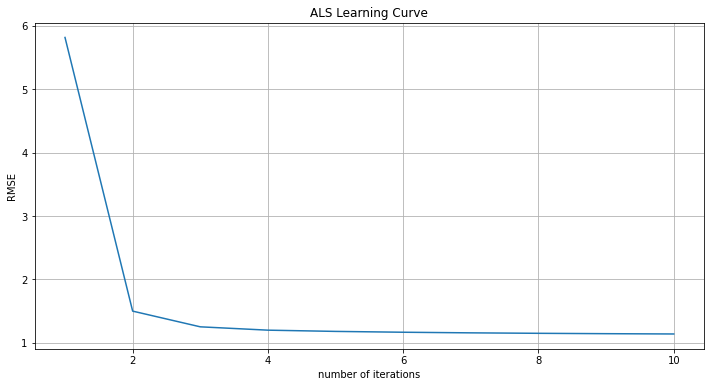

In [46]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, valid, 0.05, 20)

In [47]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.1417


In [73]:
def get_animeId(df_anime, fav_anime_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    animeId_list = []
    for anime in fav_anime_list:
        animeIds = df_anime \
            .filter(anime_info.Name.like('%{}%'.format(anime))) \
            .select('anime_id') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        animeId_list.extend(animeIds)
    return list(set(animeId_list))


def add_new_user_to_data(train_data, animeId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, animeId, max_rating) for animeId in animeId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_anime, animeId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_anime.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in animeId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_anime, 
                        fav_anime_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    animeId_list = get_animeId(df_anime, fav_anime_list)
    train_data = add_new_user_to_data(ratings_data,animeId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_anime, animeId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_anime.filter(anime_info.anime_id.isin(topn_ids)) \
                    .select('Name') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [77]:
my_favorite_animes = ['One Piece']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_anime=anime_info, 
    fav_anime_list=my_favorite_animes, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_animes[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for One Piece:
1: Chengyu Donghua Lang
2: Poppoya-san: Nonki Ekichou
3: Saru Tarou Jishin ni wa Makenai zo!: Jishin e no Sonae Dai Sakusen
4: Niji no Kakehashi
5: Nikoniko♪Connie-chan
6: Sam-chan no Obake Nanka Kowaku Nai
7: Ni wa no Kotori
8: Mametarou Ganbare
9: Tsuki no Mine no Ookami
10: Trojan wo Jibun no Te de
